# Model Interpretability & Subgroup Analysis

Objective: Interpret model behavior and evaluate subgroup robustness.

In [1]:
import os
import sys
import pandas as pd 
import joblib

sys.path.append(os.path.abspath(".."))

from src.interpretability import (
    compute_permutation_importance, compute_pdp,
    compute_shap_values, compute_shap_interactions
)
from src.evaluation import evaluate_subgroups
from src.visualization import (
    plot_permutation_importance, plot_pdp, plot_shap_summary,
    plot_shap_dependence, plot_shap_interaction_pair
)

In [2]:
# Load pipeline
pipe = joblib.load("../models/final_pipeline.joblib")

# Load test data
X_test = pd.read_csv("../data/processed/X_test.csv")
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

# Load predictions
y_prob = pd.read_csv("../reports/tables/y_prob_test.csv")["y_prob"]

# Load threshold
thr = pd.read_csv("../reports/tables/thresholds.csv").iloc[0]

# Data processed
df = pd.read_csv("../data/processed/cardio_processed.csv")

In [3]:
# Permutation importance
pi = compute_permutation_importance(pipe, X_test, y_test)
pi.to_csv("../reports/tables/permutation_importance.csv", index=False)
pi.head()

,feature,importance_mean,importance_std
0,num__ap_hi,0.116942,0.002334
1,num__age_years,0.022987,0.001110
2,cat__cholesterol_3,0.014801,0.001532
3,cat__clinical_risk_flag_0,0.011304,0.000837
4,cat__cholesterol_1,0.005748,0.000910


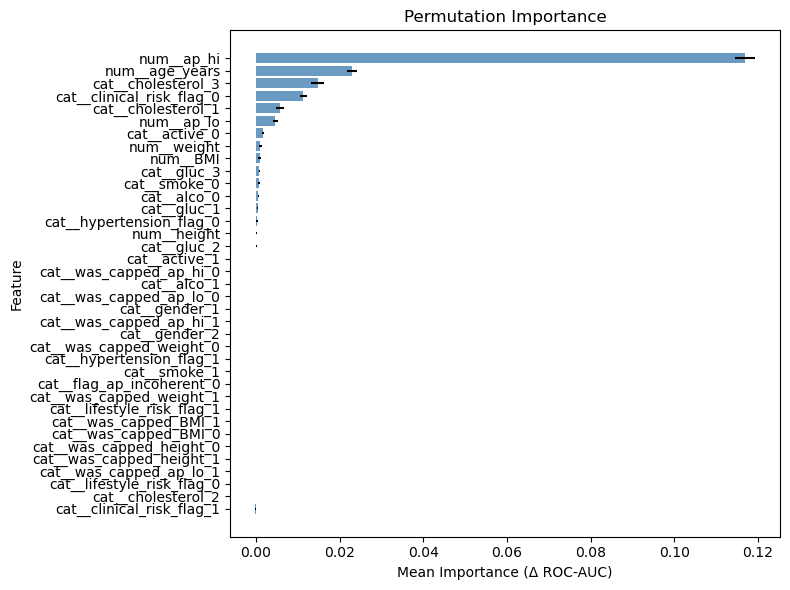

In [4]:
# Visualization
fig = plot_permutation_importance(pi)
fig.savefig("../reports/figures/permutation_importance.png", dpi=300)

In [5]:
# Subgroup analysis
sub = evaluate_subgroups(
    df.loc[X_test.index],
    y_test,
    y_prob,
    thr["youden"],
    group_cols=["gender", "age_band"]
)

sub.to_csv("../reports/tables/subgroup_metrics.csv", index=False)
sub

,subgroup,value,n,TP,FP,FN,TN,sensitivity,specificity,PPV,NPV
0,gender,2,4764,1653,586,738,1787,0.691343,0.753055,0.738276,0.707723
1,gender,1,8989,3046,1110,1367,3466,0.690233,0.757430,0.732916,0.717153
2,age_band,"[50,60)",6937,2390,825,1093,2629,0.686190,0.761146,0.743390,0.706341
3,age_band,"[40,50)",3875,1250,501,582,1542,0.682314,0.754772,0.713878,0.725989
4,age_band,"[60,70)",2569,931,330,370,938,0.715603,0.739748,0.738303,0.717125
5,age_band,"[0,40)",372,128,40,60,144,0.680851,0.782609,0.761905,0.705882


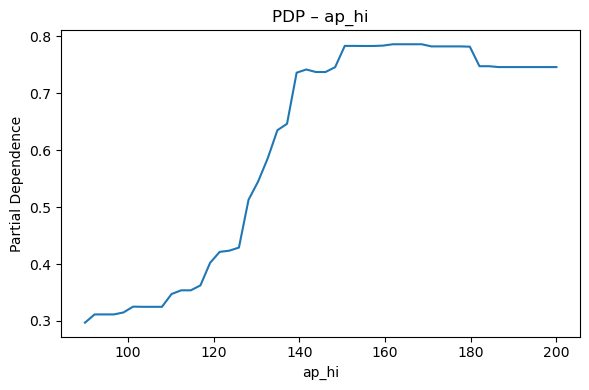

In [6]:
# PDP – ap_hi
grid, pdp_vals = compute_pdp(pipe, X_test, "ap_hi")
fig = plot_pdp(grid, pdp_vals, "ap_hi")
fig.savefig("../reports/figures/pdp_ap_hi.png", dpi=300)

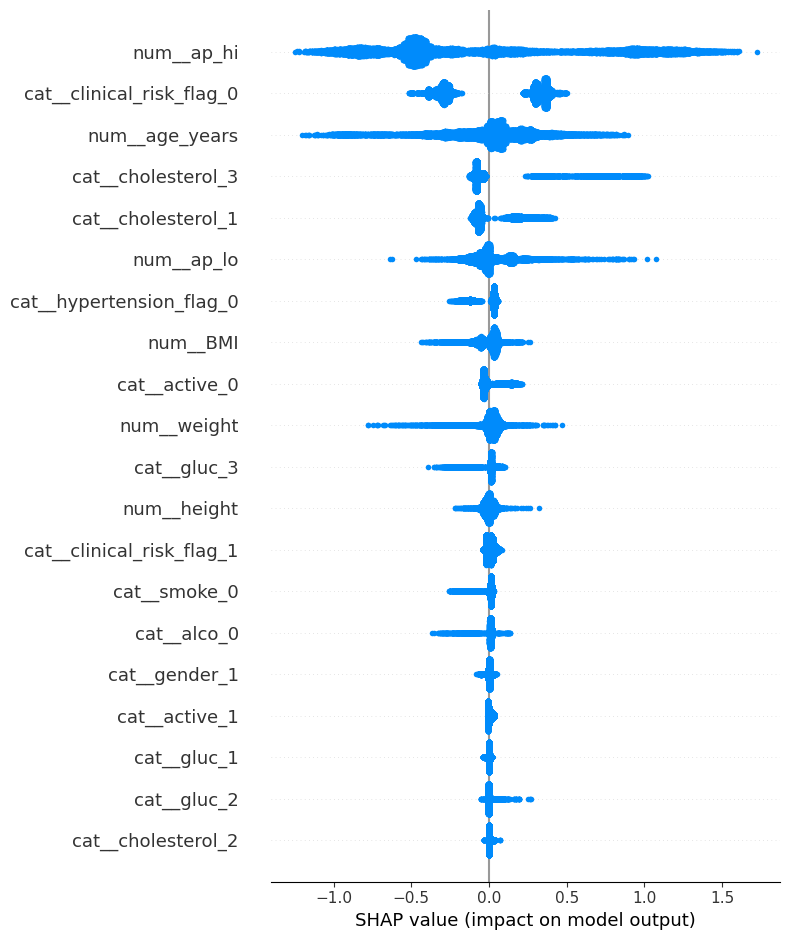

In [7]:
# SHAP values
shap_values, feature_names = compute_shap_values(pipe, X_test)

fig = plot_shap_summary(shap_values, feature_names)
fig.savefig("../reports/figures/shap.png", dpi=300)

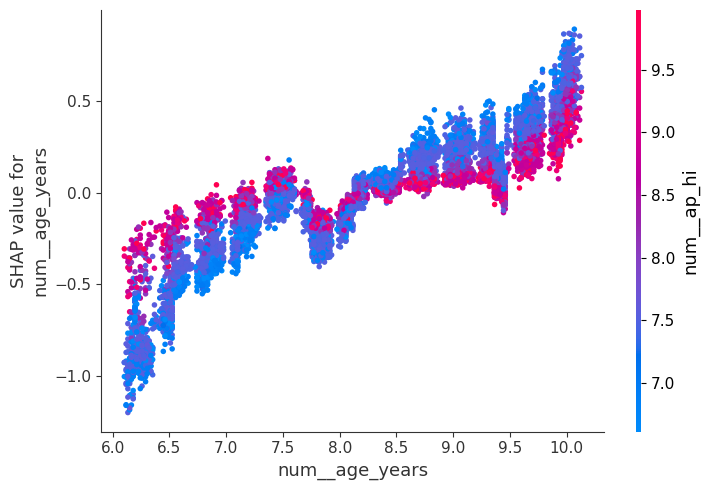

In [8]:
# Dependence plot age_years
fig = plot_shap_dependence(shap_values, X_test, pipe, feature="age_years")
fig.savefig("../reports/figures/shap_age_years.png", dpi=300)

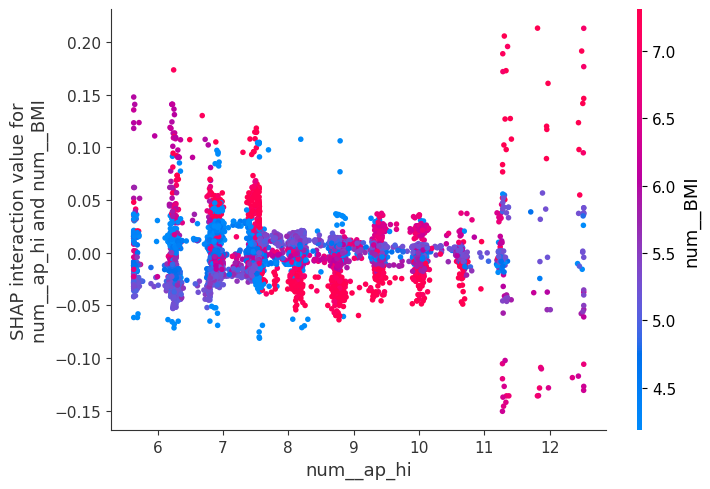

In [9]:
# Compute SHAP interaction values
interaction_values, feature_names = compute_shap_interactions(pipe, X_test)

# ap_hi × BMI interaction plot
fig = plot_shap_interaction_pair(interaction_values, X_test, pipe,
    feature1="ap_hi", feature2="BMI")
fig.savefig("../reports/figures/shap_interaction_ap_hi_BMI.png", dpi=300)